# **COVID19 SEVERITY SCREENING SYSTEM USING MACHINE LEARNING TECHNIQUE**

Written by: Abang Mohd Irham Amiruddin Bin Yusuf

Data source: https://springernature.figshare.com/articles/dataset/Data_associated_with_the_article_Epidemiological_and_clinical_characteristics_of_imported_cases_with_COVID-19_infection_a_multicentre_study/12159918

## 4.1 Data Preprocessing

In [22]:
import pandas as pd
import numpy as np

data = pd.read_csv("data\data.csv")
data.head()

,ID,District,Gender,Age,Distribution,Outcome,Fever,Cough,Fatigue,Dyspnea,...,Contact,Contact-W,Contact-C,Time-1,Time-2,Time-3,Cluster,Cluster-F,Cluster-O,Type
0,1,1,2,29,1,2,1,0,0,0,...,1,0,0,11.0,2.0,9,1,1,0,2
1,2,1,1,29,1,2,1,0,0,0,...,1,0,0,11.0,2.0,9,1,1,0,2
2,3,1,1,34,1,2,1,0,1,0,...,1,1,0,7.0,2.0,3,1,0,1,2
3,4,1,1,34,1,2,1,0,1,0,...,1,1,0,1.0,8.0,1,1,0,1,2
4,5,1,2,65,1,1,0,1,0,1,...,1,1,0,NaN,6.0,7,1,1,0,3


In [23]:
data.shape

(478, 22)

### 4.1.1 Data Cleaning

In [24]:
# remove irrelevant columns 
data = data.drop(['ID','District','Distribution','Outcome','Contact','Contact-W',
                  'Contact-C','Cluster','Cluster-F','Cluster-O','Time-1','Time-2','Time-3'],axis=1)
data.head()

,Gender,Age,Fever,Cough,Fatigue,Dyspnea,Headache,H-Temperature,Type
0,2,29,1,0,0,0,0,38.0,2
1,1,29,1,0,0,0,0,38.0,2
2,1,34,1,0,1,0,1,38.8,2
3,1,34,1,0,1,0,0,37.8,2
4,2,65,0,1,0,1,0,36.9,3


In [25]:
# check for missing data
data.isnull().sum()

Gender           0
Age              0
Fever            0
Cough            0
Fatigue          0
Dyspnea          0
Headache         0
H-Temperature    0
Type             0
dtype: int64

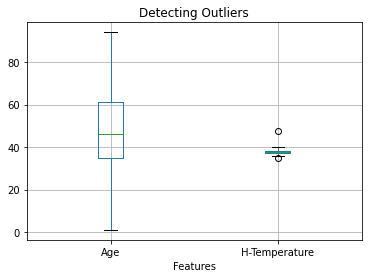

In [26]:
# use boxplot to find outliers

import matplotlib.pyplot as plt
data.boxplot(column=['Age','H-Temperature'])
plt.title("Detecting Outliers")
plt.xlabel('Features')
plt.show()

In [27]:
# function to detect outliers in a column

def findOutliers(data,col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3 - q1
    
    upper_bound = q3 + (1.5 * iqr)
    lower_bound = q1 - (1.5 * iqr)
    
    outliersList = data.index[ (data[col] < lower_bound) | (data[col] > upper_bound)] 
    
    return outliersList

In [28]:
# find outliers in the columns

indexList = []
for col in ['Age','H-Temperature']:
    indexList.extend(findOutliers(data,col))

In [29]:
# remove the outliers

def removeOutliers(data,outliersList):
    outliersList = sorted(set(outliersList))
    data = data.drop(outliersList)
    return data

data = removeOutliers(data,indexList)

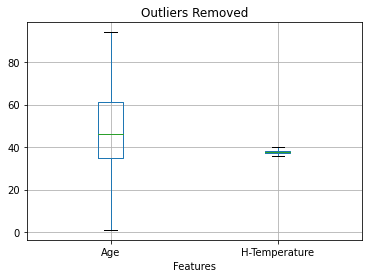

In [30]:
# check outliers

import matplotlib.pyplot as plt
data.boxplot(column=['Age','H-Temperature'])
plt.title("Outliers Removed")
plt.xlabel('Features')
plt.show()

### 4.1.2 Data Transformation

In [31]:
def transform_age(x):
    if x <= 18:
        return 1 #child
    elif x > 18 and x < 65:
        return 2 #adult
    elif x >= 65:
        return 3 #old

data['Age'] = data['Age'].apply(transform_age)

In [32]:
def transform_temp(x):
    if x < 37.3:
        return 1
    elif x >= 37.3 and x <= 38:
        return 2 
    elif x >= 38.1 and x <= 39:
        return 3
    else:
        return 4

data['H-Temperature'] = data['H-Temperature'].apply(transform_temp)

### 4.1.3 Data Balancing

In [33]:
X = data.drop(columns="Type")
y = data["Type"]

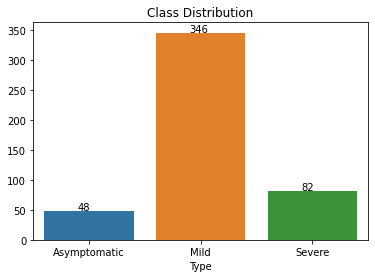

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# check balance data
ax = sns.barplot(x=['Asymptomatic','Mild','Severe'],
                 y=[sum(y==1),sum(y==2),sum(y==3)])

for i,v in enumerate([sum(y==1),sum(y==2),sum(y==3)]):
    ax.text(i - .1,v + 1,v)
    
ax.set_title("Class Distribution")
ax.set_xlabel('Type')
plt.savefig('targetDistribution.jpg',bbox_inches='tight')
plt.show()

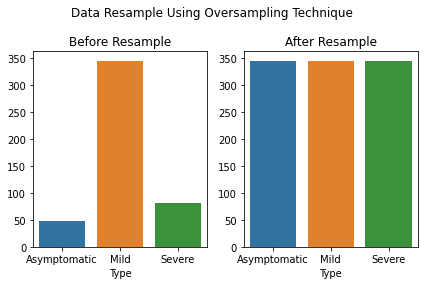

In [35]:
# barplot before balancing
fig, (ax1,ax2) = plt.subplots(1,2)
sns.barplot(x=['Asymptomatic','Mild','Severe'],
            y=[sum(y==1),sum(y==2),sum(y==3)],ax=ax1)
ax1.set_title("Before Resample")
ax1.set_xlabel('Type')

# oversampling technique
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X,y = sm.fit_resample(X,y)

sns.barplot(x=['Asymptomatic','Mild','Severe'],
            y=[sum(y==1),sum(y==2),sum(y==3)],ax=ax2)
ax2.set_title("After Resample")
ax2.set_xlabel('Type')

plt.suptitle("Data Resample Using Oversampling Technique")
plt.tight_layout()
plt.savefig('resampled.jpg',bbox_inches='tight')
plt.show()

## 4.2 Feature Selection

In [36]:
# splitting dataset into testing and training dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

### 4.2.1 Filter Method: Pearson Correlation

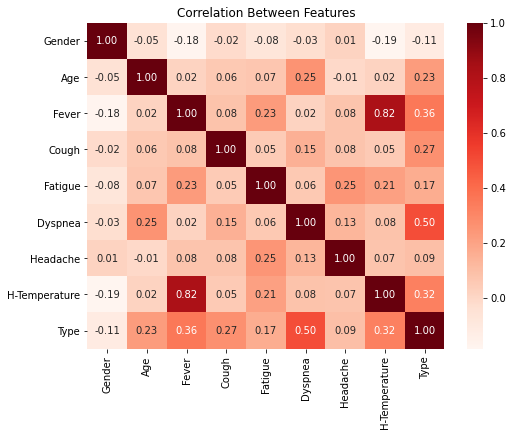

In [37]:
# Using Pearson Correlation
import seaborn as sns

plt.figure(figsize=(8,6))
cor = data.corr(method ='pearson')
sns.heatmap(cor, annot=True, fmt='.2f',cmap=plt.cm.Reds)  
plt.title("Correlation Between Features")
plt.savefig('pearsonsCorrelation.jpg',bbox_inches='tight')
plt.show()

In [38]:
#Correlation with output variable
cor_target = abs(cor["Type"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
print(relevant_features)

Fever            0.355900
Dyspnea          0.499406
H-Temperature    0.324614
Type             1.000000
Name: Type, dtype: float64


In [39]:
corr_vars = set()
corr_vars.update(relevant_features.index.unique(level=0))
all_vars = set(data.columns)
feature_cor = X.drop(columns=all_vars - corr_vars).columns

### 4.2.2 Embedded Method: Random Forest Importance

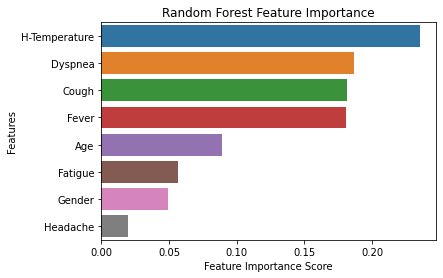

In [40]:
# embedded method: random forest feature selection
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=10)
clf.fit(X_train,y_train)

feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Random Forest Feature Importance")
plt.savefig('RandomForestFeatureImportance.jpg',bbox_inches='tight')
plt.show()

In [77]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=10)
sel = SelectFromModel(clf)
sel.fit(X_train,y_train)
sel.get_support()
feature_sel = X.columns[(sel.get_support())]

print("Selected Feature:")
for i in range (0,len(feature_sel)):
    print(i+1,'-',feature_sel[i])

Selected Feature:
1 - Fever
2 - Cough
3 - Dyspnea
4 - H-Temperature


### 4.2.3 RFE

In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

min_features=1
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=10),
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features,
)
rfecv.fit(X_train,y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 7


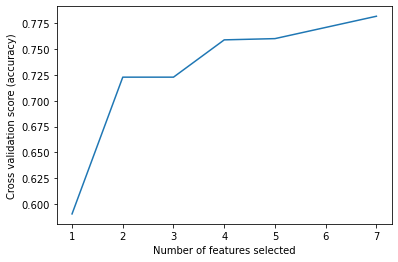

In [88]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features, len(rfecv.grid_scores_) + min_features),
    rfecv.grid_scores_
)
plt.savefig('rfe.jpg',bbox_inches='tight')
plt.show()

In [86]:
# display selected features
cols = list(X.columns)
feature_rfe = []
for i in range(X.shape[1]):
    if rfecv.ranking_[i] == 1:
        feature_rfe.append(cols[i])
print(feature_rfe)

['Gender', 'Age', 'Fever', 'Cough', 'Fatigue', 'Dyspnea', 'H-Temperature']


### 4.2.4 Feature Selection Method Comparison

In [51]:
# compare accuracy from each feature selection method

from sklearn import metrics

clf = RandomForestClassifier(random_state=10)

# accuracy of correlation method
clf.fit(X_train[feature_cor],y_train)
y_pred = clf.predict(X_test[feature_cor])
cor_accuracy = metrics.accuracy_score(y_test,y_pred)

# accuracy of tree based feature selection (embedded method)
clf.fit(X_train[feature_sel],y_train)
y_pred = clf.predict(X_test[feature_sel])
sel_accuracy = metrics.accuracy_score(y_test,y_pred)

# accuracy of rfe
clf.fit(X_train[feature_rfe],y_train)
y_pred = clf.predict(X_test[feature_rfe])
rfe_accuracy = metrics.accuracy_score(y_test,y_pred)

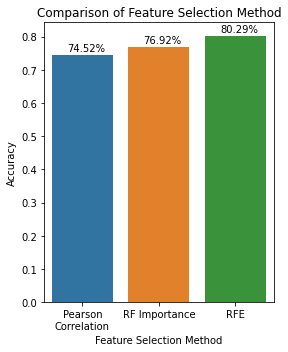

In [52]:
# plotting the comparison between the feature selection method

plt.subplots(figsize=(4,5))

method = ['Pearson\nCorrelation','RF Importance','RFE']
accuracy = [cor_accuracy,sel_accuracy,rfe_accuracy]

ax = sns.barplot(x=method,y=accuracy)
ax.set_xlabel('Feature Selection Method')
ax.set_ylabel('Accuracy')
for i,v in enumerate(accuracy):
    ax.text(i - .2,v + .01,"{:.2%}".format(v))

plt.title("Comparison of Feature Selection Method")
plt.tight_layout()
plt.show()

## 4.3 Machine Learning Model Comparison

In [57]:
# update X_train,X_test
X_train = X_train[feature_rfe]
X_test = X_test[feature_rfe]

### 4.3.1 Naive Bayes Model

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

nb_model = GaussianNB()
nb_model.fit(X_train,y_train)
y_pred = nb_model.predict(X_test)

nb_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy(Naive Bayes):","{:.2%}".format(nb_accuracy))

Accuracy(Naive Bayes): 75.48%


In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

grid_search = GridSearchCV(estimator = nb_model, param_grid = param_grid, 
                          cv = 5, n_jobs=-1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=2)

In [60]:
grid_search.best_params_, grid_search.best_score_

({'var_smoothing': 0.0533669923120631}, 0.7710843373493976)

In [61]:
optimized_nb = grid_search.best_estimator_
optimized_nb.fit(X_train, y_train)

y_pred = optimized_nb.predict(X_test)
nb_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy(Naive Bayes):","{:.2%}".format(nb_accuracy))

Accuracy(Naive Bayes): 78.37%


### 4.3.2 Gradient Boosting Classifier

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=10)
gb_model.fit(X_train,y_train)
y_pred = gb_model.predict(X_test)

gb_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy(GB Decision Tree):","{:.2%}".format(gb_accuracy))

Accuracy(GB Decision Tree): 77.88%


In [63]:
from sklearn.model_selection import GridSearchCV

max_features_range = np.arange(1,6,1)
n_estimators_range = np.arange(10,110,10)

param_grid = {
    'max_features': max_features_range,
    'n_estimators': n_estimators_range
}

grid_search = GridSearchCV(estimator = gb_model, param_grid = param_grid, 
                          cv = 5, n_jobs=-1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'max_features': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             verbose=2)

In [64]:
grid_search.best_params_, grid_search.best_score_

({'max_features': 4, 'n_estimators': 20}, 0.7819277108433735)

In [65]:
optimized_gb = grid_search.best_estimator_
optimized_gb.fit(X_train, y_train)

y_pred = optimized_gb.predict(X_test)
gb_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy(GB Decision Tree):","{:.2%}".format(gb_accuracy))

Accuracy(GB Decision Tree): 78.85%


### 4.3.3 Random Forest Model

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=10)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

rf_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy(Random Forest):","{:.2%}".format(rf_accuracy))

Accuracy(Random Forest): 80.29%


In [67]:
from sklearn.model_selection import GridSearchCV

max_features_range = np.arange(1,6,1)
n_estimators_range = np.arange(10,110,10)

param_grid = {
    'max_features': max_features_range,
    'n_estimators': n_estimators_range
}

grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 5, n_jobs=-1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_features': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             verbose=2)

In [68]:
grid_search.best_params_, grid_search.best_score_

({'max_features': 1, 'n_estimators': 30}, 0.7927710843373494)

In [69]:
optimized_rf = grid_search.best_estimator_
optimized_rf.fit(X_train, y_train)

y_pred = optimized_rf.predict(X_test)
rf_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy(Random Forest):","{:.2%}".format(rf_accuracy))

Accuracy(Random Forest): 80.77%


### 4.3.4 Model Comparison

In [70]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(optimized_nb, X, y, cv=5)
nb_accuracy_mean = scores.mean()

In [71]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(optimized_gb, X, y, cv=5)
gb_accuracy_mean = scores.mean()

In [72]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(optimized_rf, X, y, cv=5)
rf_accuracy_mean = scores.mean()

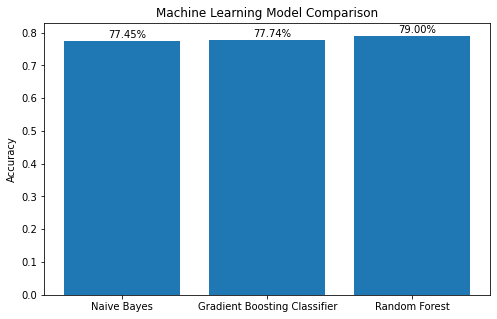

In [89]:
model = ['Naive Bayes','Gradient Boosting Classifier','Random Forest']
accuracy = [nb_accuracy_mean,gb_accuracy_mean,rf_accuracy_mean]

plt.figure(figsize=(8,5))

plt.bar(model, accuracy)
plt.title('Machine Learning Model Comparison')
plt.ylabel('Accuracy')
for i,v in enumerate(accuracy):
    plt.text(i - .1,v + .01,"{:.2%}".format(v))

plt.show()

In [91]:
# save the model to disk
import pickle

filename = 'model\predictive_model.sav'

tuple_objects = (optimized_rf, rf_accuracy_mean)

# Save tuple
pickle.dump(tuple_objects, open(filename, 'wb'))